### Purpose

This Jupyter notebook contains pilot data exploring the relationship between PM2.5 and cardiopulmonary hospital ED visits in Washington state from 2010 to 2015 using a time-series study design. I am evaluating PM2.5's effect on CVD events using a non-linear distributed lag model to look at varying levels of PM2.5.

Starting by loading R libraries necessary for project.

In [1]:
# load libraries
library(tidyverse)
library(splines)
library(dlnm)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1.9000     ✔ purrr   0.2.4     
✔ tibble  1.4.2          ✔ dplyr   0.7.4     
✔ tidyr   0.8.0          ✔ stringr 1.3.0     
✔ readr   1.1.1          ✔ forcats 0.3.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::vars()   masks ggplot2::vars()
This is dlnm 2.3.4. For details: help(dlnm) and vignette('dlnmOverview').


Setting up a lag function to work within dplyr.

In [2]:
# defining a lag function
funlag <- function(var, n=7){
  var <- enquo(var)
  indices <- seq_len(n)
  map( indices, ~quo(lag(!!var, !!.x)) ) %>% 
    set_names(sprintf("%s_lag%d", rlang::quo_text(var), indices))
}

Reading in 2010 to 2015 county-level time-series of Washington CHARS data.

In [16]:
wa_ts <- read_csv('../../data/health/1015-morbidity_pm_ts.csv') %>% 
    filter(state == "Washington") %>% 
    arrange(fips, date) %>% 
    group_by(county) %>% 
    mutate(., !!!funlag(pm_krig, 5), !!!funlag(temp_f, 5))  %>% 
    ungroup() %>% 
    filter(!is.na(pm_krig_lag5)) %>% 
    mutate(season = case_when(month %in% c(12,1,2)~ "winter",
                             month %in% 3:5 ~ "spring",
                             month %in% 6:8 ~ "summer",
                             month %in% 9:11 ~ "fall"))

Parsed with column specification:
cols(
  .default = col_integer(),
  state = col_character(),
  county = col_character(),
  fips = col_character(),
  date = col_date(format = ""),
  day = col_character(),
  pm_krig = col_double(),
  bg_pm = col_double(),
  pm_smk = col_double(),
  hms = col_double(),
  temp_k = col_double(),
  temp_f = col_double(),
  aqi_cat = col_character(),
  aqi_param = col_character(),
  aqi_site = col_character()
)
See spec(...) for full column specifications.


In [18]:
glimpse(wa_ts)

Observations: 67,431
Variables: 48
$ state        <chr> "Washington", "Washington", "Washington", "Washington"...
$ county       <chr> "Adams", "Adams", "Adams", "Adams", "Adams", "Adams", ...
$ fips         <chr> "53001", "53001", "53001", "53001", "53001", "53001", ...
$ date         <date> 2011-01-06, 2011-01-07, 2011-01-08, 2011-01-09, 2011-...
$ day          <chr> "Thursday", "Friday", "Saturday", "Sunday", "Monday", ...
$ month        <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ year         <int> 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, ...
$ population   <int> 18875, 18875, 18875, 18875, 18875, 18875, 18875, 18875...
$ resp         <int> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ asthma       <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ copd         <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ acute_bronch <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ pneum        <i

### PM<sub>2.5</sub> Distribution

Looking at the distribution of PM2.5 values during each season.

# A tibble: 4 x 5
  season pm_mean pm_med pm_min pm_max
  <chr>    <dbl>  <dbl>  <dbl>  <dbl>
1 fall      7.96   6.16  0.     175. 
2 spring    4.42   4.03  0.623   36.9
3 summer    6.13   4.61  0.624  333. 
4 winter    8.24   7.21  0.546   49.2


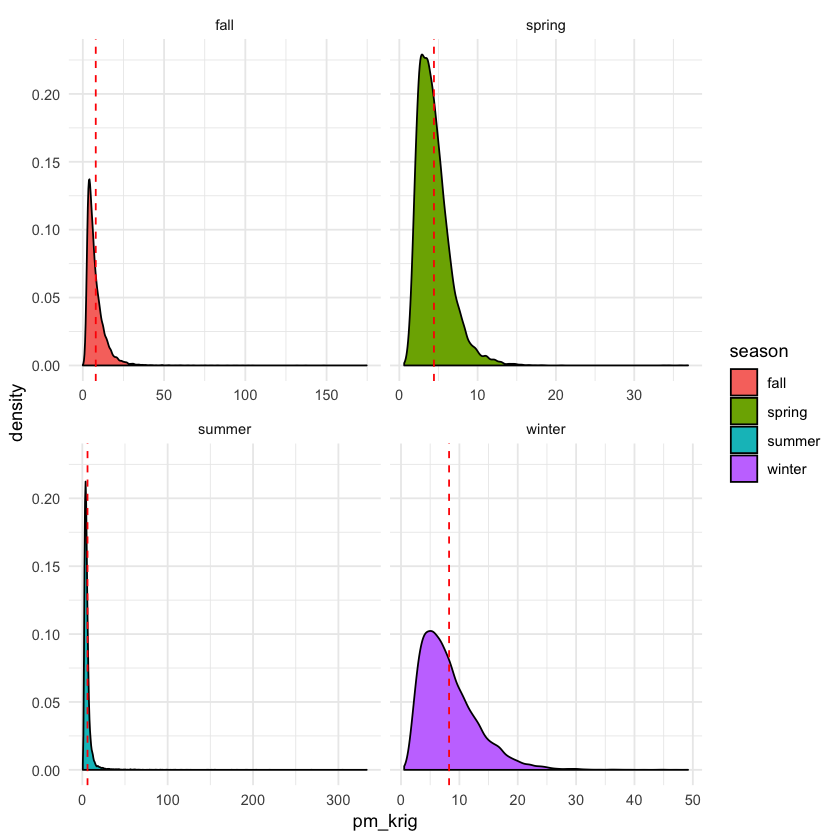

In [28]:
# find mean pm
pm_mean <- wa_ts %>% 
    group_by(season) %>% 
    summarise(pm_mean = mean(pm_krig), pm_med = median(pm_krig),
            pm_min = min(pm_krig), pm_max = max(pm_krig))

print(pm_mean)

# distribution plot of pm by season
pm_dist <- ggplot(wa_ts, aes(x=pm_krig, group = season, fill = season)) +
    geom_density() +
    geom_vline(data = pm_mean, aes(xintercept=pm_mean),
        color = "red", linetype = "dashed") +
    facet_wrap(~season, scales = "free_x") +
    theme_minimal()

print(pm_dist)